# Solving for the rest of $Y_{n+1}$ without knowing the free component.

This file is modified from the looped equation notebook.

In [1]:
# This file implements and tests recursion relations
import numpy as np
import time
import scipy.signal
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter("ignore")

# for importing parsed codes
import sys
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/parsed/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
from recursion_relations_full import *
import parsed
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'

# Profiling
import cProfile
import pstats

Detected 16 CPU's. Setting n_jobs to #CPU/2.


In [2]:
def plot_real_imag(inp):
    plt.plot(inp,label = 'real')
    plt.plot(np.imag(inp), label = 'imag')
    plt.legend()
    plt.show()

Axis shape:


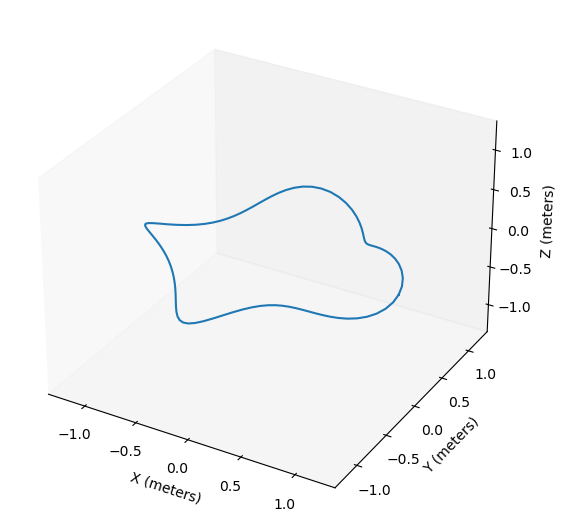

0

In [3]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'5.4/', 
        R_array=[5,0,1,4,0.17,0,8,0.018191838304685660487880483060508,0,12,0.001420200653346571223467620370684,0,16,0.000059148767213264540889769427245426,0],
        Z_array=[5,0,0,4,0,0.15464423020448464507481389773602,8,0,0.017913837381820285621358834760031,12,0,0.0014893730073718687394179749361456,16,0,0.00006923943338841940945208031088498]
    )
B_theta_coef_cp = B_theta_coef_cp.zero_append()
B_theta_coef_cp[1]

Axis shape:


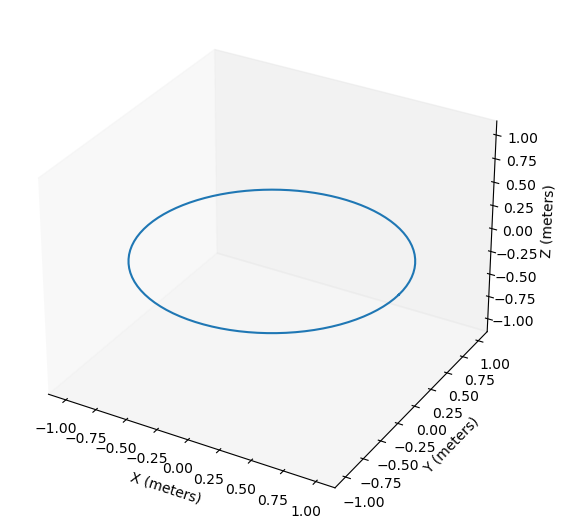

In [4]:

phis = np.linspace(0,2*np.pi*999/1000+0j,1000)
# The only case with non-trivial an-isotropic pressure
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'circ/', 
        R_array=[2,0,1,2,0.0001,0],
        Z_array=[1,2,0,0.001]
    )


## Solving $Y_{n}$order by order
The convolution matrices actually looks quite simple. Since the top and bottom elements are
not coupled to anything else, we can solve for them first.

NOTE: since both coefficients are not iterative quantities, our solver ONLY need to work well 
for these coeffs for all f. This means your solver only need to work for one particular range of 
p (unfortunately here it's ~11)

## $Y_{n+1}$
Uses $X_{n+1}, Y_n, Z_n, B_{\theta n}, B_{\psi  n-2},
\iota_{(n-2)/2 \text{or} (n-3)/2}, B_{\alpha  n/2 \text{or} (n-1)/2}$

$Y_{n+1}$ is given by (conv(a) + conv(b)@dchi)@Yn+1 = RHS - LHS(Yn+1 = 0)

Under-determined solve is neeX_coef_cpded.

## $Y_{n}$
Uses $X_{n}, Y_{n-1}, Z_{n-1}, B_{\theta n-1}, B_{\psi  n-3},
\iota_{(n-3)/2 \text{or} (n-4)/2}, B_{\alpha  (n-1)/2 \text{ or } (n-2)/2}$

In [5]:
import eval_ynp1

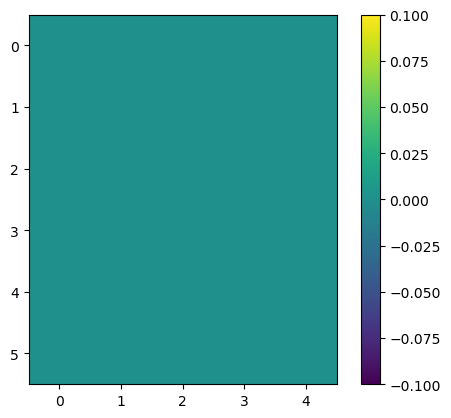

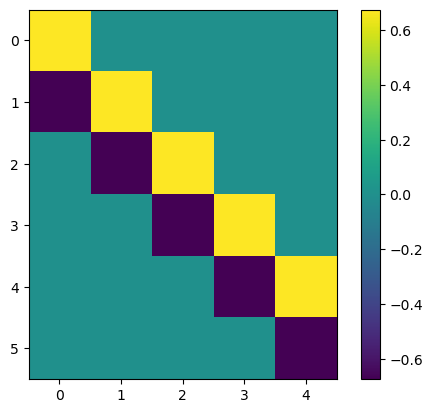

In [6]:
n_eval = 3
coef_a = eval_ynp1.coef_a(n_eval-1, B_alpha_coef, X_coef_cp)
coef_b = eval_ynp1.coef_b(B_alpha_coef, X_coef_cp)

conv_example = conv_matrix(coef_a.content[:,10], 5)
plt.imshow(np.real(conv_example))
plt.colorbar()
plt.show()
plt.imshow(np.imag(conv_example))
plt.colorbar()
plt.show()

In [7]:
n_eval = 3
coef_a = eval_ynp1.coef_a(n_eval-1, B_alpha_coef, X_coef_cp)
coef_b = eval_ynp1.coef_b(B_alpha_coef, X_coef_cp)

# Getting rhs-lhs
# for Yn to work, "n" must be subbed with n-1 here
yn_rhsmlhs = eval_ynp1.rhs_minus_lhs(n_eval-1,
    X_coef_cp,
    # Y_coef_cp.mask(n_eval) also works
    Y_coef_cp.mask(n_eval-1).zero_append(),
    Z_coef_cp,
    B_psi_coef_cp,
    B_theta_coef_cp,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef)

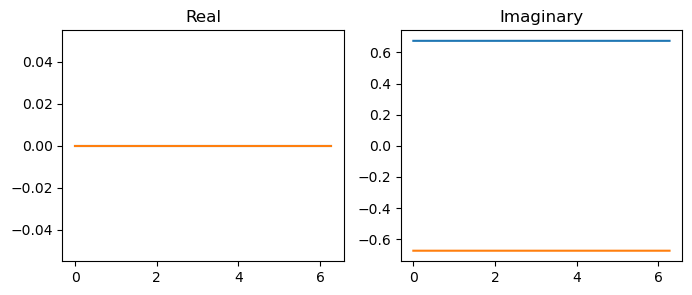

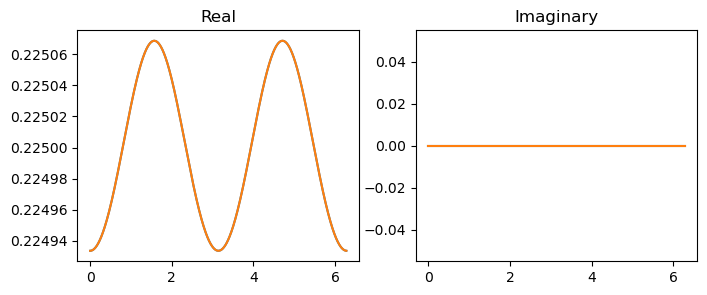

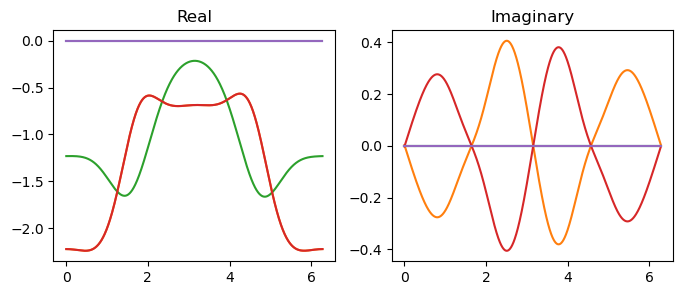

In [8]:
coef_a.display_content(fourier_mode = False)
coef_b.display_content(fourier_mode = False)
yn_rhsmlhs.display_content(fourier_mode = False)

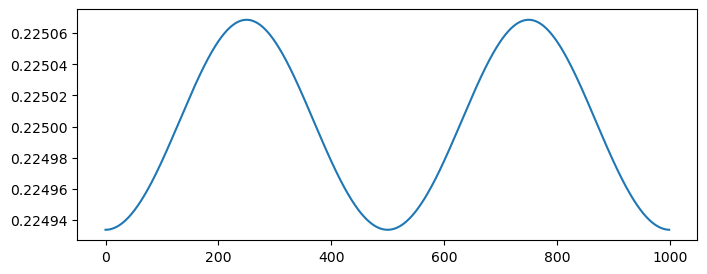

In [9]:
plt.plot(np.real(coef_b.content[1]))

In [10]:


# R and I are defined s.t.
# R[phi] * Cr = np.real(conv_matrix(coeff[:,phi], n-2))
# I[phi] * Ci = np.imag(conv_matrix(coeff[:,phi], n-2))
# Cr =
# 1  0  0 
# 1  1  0
# 0  1  1
# 0  0  1 ...
# Ci =
#-1  0  0 
# 1 -1  0
# 0  1 -1
# 0  0  1 ...
R = np.real(coef_a.content[1])
I = np.imag(coef_a.content[1])

R_dc = np.real(coef_b.content[1])
I_dc = np.imag(coef_b.content[1])

m_prev = n_eval+1 # current mode being evaluated (mode of the outmost comps)
A_minus_plus = np.array([(R - 1j*I) - 1j*(m_prev)*(R_dc - 1j*I_dc),
                         (R + 1j*I) + 1j*(m_prev)*(R_dc + 1j*I_dc)])


f_minus_plus = np.array([yn_rhsmlhs.content[0],
                        yn_rhsmlhs.content[-1]])


Inconveniently, the m=nth mode coefficient is zero. This means we have to eliminate the constant component.

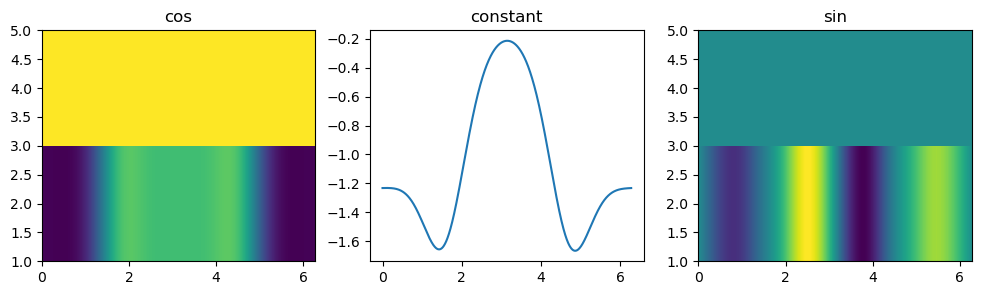

(5, 1000)


In [21]:
yn_rhsmlhs.display_content(colormap_mode = True)
print(yn_rhsmlhs.get_shape())

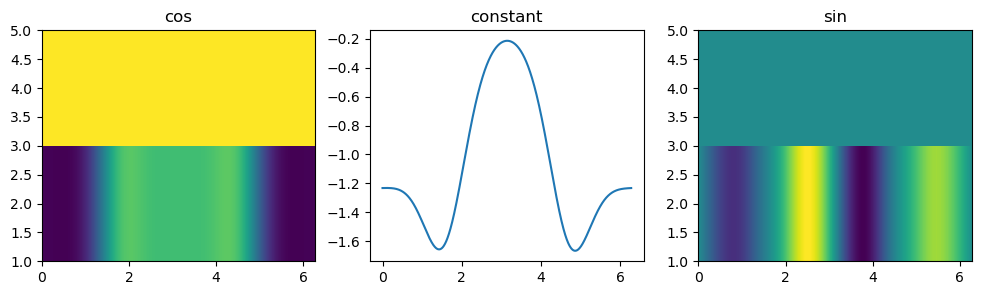

(5, 1000)


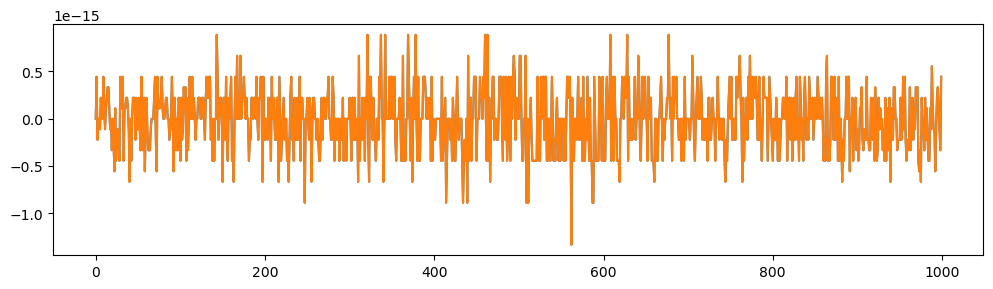

In [12]:
plt.plot(f_minus_plus.T)

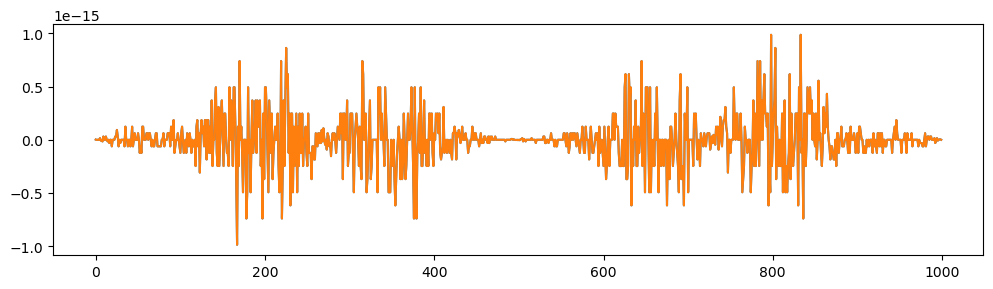

In [13]:
# solves for B_theta from 
# coef_a*B_theta 
# + coef_b*B_theta.dchi()
# = yn_rhsmlhs

len_phi = yn_rhsmlhs.get_shape()[1]
Yn_out = np.zeros((n_eval+1, len_phi), dtype = np.complex128)

# Ay = f

f_minus_plus = np.array([yn_rhsmlhs.content[0],
                        yn_rhsmlhs.content[-1]])
Yn_bottom_top = f_minus_plus/A_minus_plus

Yn_out[0] = Yn_bottom_top[0]
Yn_out[-1] = Yn_bottom_top[-1]

plt.plot(Yn_bottom_top.T)

# # (n_eval > 4 or 5, there're more components to solve
# # for than the top and bottom 2)
# if (n_eval-2)//2>1: 
#     print('Solving for inner components')
#     B_theta_prev = Yn_bottom_top
#     print('B_theta_prev',B_theta_prev.shape)
#     dp_B_theta_prev = ChiPhiFuncGrid(B_theta_prev).dphi().content
#     B_curr = B_minus_plus
#     # number of component pair besides the outmost pairs
#     for i in range((n_eval-2)//2-1): 


#         # Coeffs of the previous order
#         A_prev = np.array([(R + 1j*I) - 1j*(m_prev)*(R_dc + 1j*I_dc),
#                            (R - 1j*I) + 1j*(m_prev)*(R_dc - 1j*I_dc)])
#         B_prev = np.array([(R_dp + 1j*I_dp),
#                            (R_dp - 1j*I_dp)])
#         A_curr = np.array([(R - 1j*I) - 1j*(m_prev-2)*(R_dc - 1j*I_dc),
#                            (R + 1j*I) + 1j*(m_prev-2)*(R_dc + 1j*I_dc)])
#         # B_curr = B_minus_plus doesn't change
#         f_curr = np.array([yn_rhsmlhs.content[1+i],
#                            yn_rhsmlhs.content[-2-i]])\
#                            - A_prev * B_theta_prev - B_prev * dp_B_theta_prev
#         B_theta_curr,_ = solve_integration_factor(coeff = A_curr, 
#                          coeff_dp = B_curr, 
#                          f = f_curr)

#         Yn_out[1+i] = B_theta_curr[0]
#         Yn_out[-2-i] = B_theta_curr[-1]

#         B_theta_prev = B_theta_curr
#         dp_B_theta_prev = ChiPhiFuncGrid(B_theta_prev).dphi().content
#         m_prev = m_prev-2



B_theta_nm1.display_content()$1/p$ is well behaved. This allows us to use the asymptotic expansion on Orszag 
p258, IBP for Laplace integrals.

In [14]:
B_theta_nm1 = ChiPhiFuncGrid(solve_B_theta(yn_rhsmlhs, 4)).filter()
B_theta_nm1.display_content()

NameError: name 'solve_B_theta' is not defined

## Testing B_theta solve

In [ ]:
# testing:

rands1 = np.random.randint(5, size=16)
content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points),
    rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)
])
test1 = ChiPhiFuncGrid(content1, fourier_mode = True)

test_RHS = test_equilibrium.coeff_B_theta_nm1*test1 \
    + test_equilibrium.coeff_dc_B_theta_nm1*test1.dchi() \
    + test_equilibrium.coeff_dp_B_theta_nm1*test1.dphi()

test_guess = solve_B_theta(test_RHS, 6)
compare_chiphifunc(ChiPhiFuncGrid(test_guess).filter(), test1, simple_mode = False, fourier_mode = False)

In [ ]:
ChiPhiFuncGrid(solve_B_theta(yn_rhsmlhs, 4)).roll_avg().display_content(fourier_mode = False)

In [ ]:
np.exp(10)

In [ ]:
sln = ChiPhiFuncGrid(solve_B_theta(yn_rhsmlhs, 4)).roll_avg()
compare_chiphifunc(test_equilibrium.coeff_B_theta_nm1*sln \
    + test_equilibrium.coeff_dc_B_theta_nm1*sln.dchi() \
    + test_equilibrium.coeff_dp_B_theta_nm1*sln.dphi(), yn_rhsmlhs, simple_mode=False)

In [ ]:
sln = ChiPhiFuncGrid(solve_B_theta(yn_rhsmlhs, 4)).filter().display()
compare_chiphifunc(test_equilibrium.coeff_B_theta_nm1*sln \
    + test_equilibrium.coeff_dc_B_theta_nm1*sln.dchi() \
    + test_equilibrium.coeff_dp_B_theta_nm1*sln.dphi(), yn_rhsmlhs, simple_mode=False)

## $B_{\theta n0}$

In [ ]:
# for even n, solve for B_theta_n0
B_theta_nm1 = ChiPhiFuncGrid(solve_B_theta(yn_rhsmlhs, 4)).filter()
print('B_theta_nm1')
B_theta_nm1.display_content()

if n_eval%2 == 0: 
    # yn_rhsmlhs also includes B_theta[n,0]
    # Because B_theta[n] is also suppressed.
    constant_component = (yn_rhsmlhs - \
    - test_equilibrium.coeff_B_theta_nm1*B_theta_nm1 \
    - test_equilibrium.coeff_dc_B_theta_nm1*B_theta_nm1.dchi() \
    - test_equilibrium.coeff_dp_B_theta_nm1*B_theta_nm1.dphi()).get_constant().filter()
    B_theta_n0,_ = solve_integration_factor(
        coeff = test_equilibrium.coeff_B_theta_n0.content, 
        coeff_dp = test_equilibrium.coeff_dp_B_theta_n0.content, 
        f = constant_component.content, integral_mode = 'spline')
    
ChiPhiFuncGrid(B_theta_n0).display_content()

In [ ]:
# for even n, solve for B_theta_n0
B_theta_nm1 = ChiPhiFuncGrid(solve_B_theta(yn_rhsmlhs, 4)).filter()
print('B_theta_nm1')
B_theta_nm1.display_content()

if n_eval%2 == 0: 
    # yn_rhsmlhs also includes B_theta[n,0]
    # Because B_theta[n] is also suppressed.
    constant_component = (yn_rhsmlhs - \
    - test_equilibrium.coeff_B_theta_nm1*B_theta_nm1 \
    - test_equilibrium.coeff_dc_B_theta_nm1*B_theta_nm1.dchi() \
    - test_equilibrium.coeff_dp_B_theta_nm1*B_theta_nm1.dphi()).get_constant().filter()
    B_theta_n0,_ = solve_integration_factor(
        coeff = test_equilibrium.coeff_B_theta_n0.content, 
        coeff_dp = test_equilibrium.coeff_dp_B_theta_n0.content, 
        f = constant_component.content, integral_mode = 'spline')
    
ChiPhiFuncGrid(B_theta_n0).display_content()

In [ ]:
Yn_out = np.zeros((n_eval-2, len_phi), dtype = np.complex128)

m_prev = n_eval-3 # current mode being evaluated (mode of the outmost comps)
A_minus_plus = np.array([(R - 1j*I) - 1j*(m_prev)*(R_dc - 1j*I_dc),
                         (R + 1j*I) + 1j*(m_prev)*(R_dc + 1j*I_dc)])
B_minus_plus = np.array([(R_dp - 1j*I_dp),
                         (R_dp + 1j*I_dp)])
f_minus_plus = np.array([yn_rhsmlhs.content[0],
                        yn_rhsmlhs.content[-1]])
Yn_bottom_top = solve_integration_factor(coeff = A_minus_plus, 
                         coeff_dp = B_minus_plus, 
                         f = f_minus_plus, integral_mode = 'auto')
plt.plot(ChiPhiFuncGrid(Yn_bottom_top[0]).filter().content.T)

## Solving for $B_{\psi n-3}$ and $Y_{\psi n-1}$
These two vars are given in a pair of coupled 2nd order linear ODE
$Ay'' + By' + Cy + Dz' + Ez = f$
Where $A, B, C, D, E, f$ all have 2 components.
However, the components of $A$ ~ $E$ has a particular form:

In [ ]:
conv_example = conv_matrix(test_equilibrium.coeff_B_theta_nm1.content[:,100], 1)
plt.imshow(np.real(conv_example))
plt.colorbar()
plt.show()
plt.imshow(np.imag(conv_example))
plt.colorbar()
plt.show()